# Artem Moskalev. Home Assignment 4

Please, write your implementation within the designated blocks:
```python
...
### BEGIN Solution

# >>> your solution here <<<

### END Solution
...
```

Write your theoretical derivations within such blocks:
```markdown
**BEGIN Solution**

<!-- >>> your derivation here <<< -->

**END Solution**
```

## $\LaTeX$ in Jupyter
Jupyter has constantly improving $\LaTeX$ support. Below are the basic methods to
write **neat, tidy, and well typeset** equations in your notebooks:
* to write an **inline** equation use 
```markdown
$ you latex equation here $
```
* to write an equation, that is **displayed on a separate line** use 
```markdown
$$ you latex equation here $$
```
* to write a **block of equations** use 
```markdown
\begin{align}
    left-hand-side
        &= right-hand-side on line 1
        \\
        &= right-hand-side on line 2
        \\
        &= right-hand-side on the last line
\end{align}
```
The **ampersand** (`&`) aligns the equations horizontally and the **double backslash**
(`\\`) creates a new line.

<br/> <!--Intentionally left blank-->

# GLM Bayesian Models

In [1]:
import numpy as np
import pandas as pd

import torch

%matplotlib inline
import matplotlib.pyplot as plt

## Task 1: Theoretical problem

Consider a univariate Gaussian distribution $\mathcal{N}(x; \mu, \tau^{-1})$.
Let's define Gaussian-Gamma prior for parameters $(\mu, \tau)$:

\begin{equation}
    p(\mu, \tau)
        = \mathcal{N}(\mu; \mu_0, (\beta \tau)^{-1})
            \otimes \text{Gamma}(\tau; a, b)
        \,.
\end{equation}

Find the posterior distribution of $(\mu, \tau)$ after observing $X = (x_1, \dots, x_n)$.

**BEGIN Solution**

$Gamma(\tau;a,b) = \frac 1 {Г(a)b}\tau^{(a-1)}e^{- \frac \tau b}$

$\mathcal{N}(\mu; \mu_0, (\beta\tau)^{-1}) = \frac 1 {(\beta \tau)^{-1}\sqrt{2\pi}} e^{\frac {(\mu - \mu_0)^2} {2(\beta \tau)^{-2}}}$
<br><br><br>

$
p(\mu, \tau |X) \propto p(X|\mu,\tau)p(\mu, \tau) = \frac {\tau^{n+1}} {(\sqrt{2\pi})^n+1} 
\prod_{i=1}^n e^{- \frac {(x_i-\mu)^2\tau^2} {2}} \frac 1 {(\beta \tau)^{-1}\sqrt{2\pi}} e^{\frac {(\mu - \mu_0)^2} {2(\beta \tau)^{-2}}} \frac 1 {Г(a)b}\tau^{(a-1)}e^{- \frac \tau b} =
$

$
\frac {\beta \tau^{a+n}} {(\sqrt{2\pi})^n+1} exp[- \frac {\tau^2} 2 \sum_{i=1}^n (x_i - \mu)^2 - \frac {(\mu-\mu_0)^2} {\beta \tau^2} - \tau \beta^{-1}] \frac 1 {Г(a)b}\tau^{(a-1)}e^{- \frac \tau b}
$


Our posterior appeared to be Gaussian-Gamma as well, which seems to be reasonable


**END Solution**

<br/> <!--Intentionally left blank-->

## Task 2: Practical problem

Evaluate the following integral using the Laplace approximation:
\begin{equation}
    x \mapsto \int \sigma(w^T x) \mathcal{N}(w; 0, \Sigma) dw \,,
\end{equation}
for $x = \bigl(\tfrac23, \tfrac16, \tfrac16\bigr)\in \mathbb{R}^3$ and 
\begin{equation}
    \Sigma
        = \begin{pmatrix}
             1    & -0.25 & 0.75 \\
            -0.25 &  1    & 0.5  \\
             0.75 &  0.5  & 2
           \end{pmatrix}
        \,.
\end{equation}

### Part 2.1
Use the Hessian matrix computed numericaly via finite differences. (Check out [Numdifftools](https://pypi.python.org/pypi/Numdifftools))

In [2]:
import numdifftools as ndt
import scipy.stats as stats
import scipy.optimize as opt
from torch.autograd import Variable

In [3]:
### BEGIN Solution

S = np.array([[1.,-.25,.75], [-.25,1.,.5], [.75,.5,2.]])
x_init = np.array([2/3, 1/6, 1/6])

def F(x, x_init, cov):
    denom = np.exp(-1.*x@x_init)+1.
    nrm = stats.multivariate_normal.pdf(x, cov=cov)
    return nrm/denom

def logF(x):
    return -1*np.log(F(x, x_init, S))

In [4]:
optW = opt.minimize(logF,np.zeros(3)).x

deter = np.linalg.det(ndt.Hessian(logF)(optW))
int_val = F(optW,x_init,S)*np.sqrt(np.power(np.pi*2,3)/deter)

In [5]:
print('Integral value:', int_val)

Integral value: 0.497919722304


<br/> <!--Intentionally left blank-->

### Part 2.2
Use the diagonal approximation of the Hessian computed by autodifferentiation
in **pytorch**.

In [6]:
def torchLog(x):
    x_var, sigma_var = Variable(torch.FloatTensor(x_init)), Variable(torch.FloatTensor(np.linalg.inv(S)))
    det_S = np.sqrt(np.linalg.det(S))
    
    exp_n = torch.exp(-.5*x@sigma_var@x)*(np.power(np.power(np.sqrt(np.pi*2),3),-1) / det_S)
    
    return torch.log(torch.mul(torch.sigmoid(torch.dot(x,x_var)),exp_n))

In [7]:
def HessianTorch(x, sol):
    gr_param, out = torch.autograd.grad(sol, x, create_graph=True)[0], torch.zeros((3,3))
    for i in range(3):
        out[i] = torch.autograd.grad(gr_param[i],x,create_graph=True)[0].data
    return out.numpy().T

In [8]:
optW_var = Variable(torch.FloatTensor(optW), requires_grad=True)
deter = np.absolute(np.linalg.det(HessianTorch(optW_var, torchLog(optW_var))))
int_val_torch = F(optW,x_init,S)*np.sqrt(np.power(np.pi*2,3)/deter)

In [9]:
print('Integral Val. with PyTorch:', int_val_torch)

Integral Val. with PyTorch: 0.497919811884


<br/> <!--Intentionally left blank-->

### Part 2.3

Compare the results

It's hard to compare results directly with each other, we need one more element in one comparison to see are our results are adequate at all. For this purpose, we can, for example, try to use monte carlo estimation:

In [28]:
def intMC(N):
    return np.mean(1./(np.exp(-stats.multivariate_normal.rvs(np.zeros(3), S, size=N)@x_init)+1))

In [48]:
print('numdifftools:', int_val)
print('Monte Carlo:', intMC(1000000))
print('PyTorch:', int_val_torch)

numdifftools: 0.497919722304
Monte Carlo: 0.50022013895
PyTorch: 0.497919811884


In [49]:
print(intMC(1000000) - int_val_torch)
print(intMC(1000000) - int_val)

0.00211325199733
0.00202320997674


<br/> <!--Intentionally left blank-->

## Task 3: Gaussian Process (theoretical)

### Part 3.1

Assuimng the matrices $A \in \mathbb{R}^{n \times n}$ and $D \in \mathbb{R}^{d \times d}$
are invertable, using **gaussian elimination** find the inverse matrix for the following
block matrix:
\begin{equation}
    \begin{pmatrix} A & B \\ C & D \end{pmatrix} \,,
\end{equation}
where $C \in \mathbb{R}^{d \times n}$ and $B \in \mathbb{R}^{n \times d}$.

**BEGIN Solution**

$
\begin{pmatrix} 
A & B & I & 0\\ 
C & D & 0 & I
\end{pmatrix} \rightarrow [row2-CA^{-1}*row1] \rightarrow 
\begin{pmatrix} 
A & B          & I & 0\\ 
0 & D-CA^{-1}B & -CA^{-1} & I
\end{pmatrix} \rightarrow [row1-B(D-CA^{-1}B)^{-1}*row2] \rightarrow 
$
<br><br><br>
$
\begin{pmatrix} 
A & 0          & I+B(D-CA^{-1}B)^{-1}CA^{-1} & -B(D-CA^{-1}B)^{-1}\\ 
0 & D-CA^{-1}B & -CA^{-1}                    & I
\end{pmatrix} \rightarrow [row1*A^{-1}; row2*(D-CA^{-1}B)^{-1}] \rightarrow 
$ 
<br><br><br>
$
\begin{pmatrix} 
I & 0 & A^{-1}+A^{-1}B(D-CA^{-1}B)^{-1}CA^{-1} & -A^{-1}B(D-CA^{-1}B)^{-1}\\ 
0 & I & -(D-CA^{-1}B)^{-1}CA^{-1}              & (D-CA^{-1}B)^{-1}
\end{pmatrix} \Rightarrow 
$ 
<br><br><br>
$
\begin{pmatrix} 
A^{-1}+A^{-1}B(D-CA^{-1}B)^{-1}CA^{-1} & -A^{-1}B(D-CA^{-1}B)^{-1}\\ 
-(D-CA^{-1}B)^{-1}CA^{-1}              & (D-CA^{-1}B)^{-1}
\end{pmatrix}
$ is the inverse matrix we are looking for. However, to claim that this inverse exists it's not sufficient to say that just A and D are invertible, we have to be sure that $D-CA^{-1}B$ is also invertible and, unfortunately, there is no way that invertible A and D guarantees that (there exist such 2x2 matricies that both A and D are invertible, but whole matrix is singular).

**END Solution**

<br/> <!--Intentionally left blank-->

## Task 4: Gaussian Process (practical)

> In the late 1950’s Charles Keeling invented an accurate way to measure atmospheric $CO_2$ concentration and began taking regular measurements at the Mauna Loa observatory.

Download the data from http://scrippsco2.ucsd.edu/data/atmospheric_co2/mlo

### Part 4.1: Preprocessing

Take `monthly_in_situ_co2_mlo.csv` dataset, load it and prepare the data.

**ATTENTION** The first couple of lines of the file contain the description of
the dataset. Make sure to **read it** carefully.

Here is what the dataset might look like when loaded:
<table border="1" class="dataframe">
  <thead>
    <tr>
      <th></th>
      <th>Yr</th>
      <th>Mn</th>
      <th>Date</th>
      <th>Date</th>
      <th>CO2</th>
      <th>seasonally</th>
      <th>fit</th>
      <th>seasonally</th>
      <th>CO2</th>
      <th>seasonally</th>
    </tr>
    <tr>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th>adjusted</th>
      <th></th>
      <th>adjusted fit</th>
      <th>filled</th>
      <th>adjusted filled</th>
    </tr>
    <tr>
      <th></th>
      <th></th>
      <th></th>
      <th>Excel</th>
      <th></th>
      <th>[ppm]</th>
      <th>[ppm]</th>
      <th>[ppm]</th>
      <th>[ppm]</th>
      <th>[ppm]</th>
      <th>[ppm]</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>45</th>
      <td>1961</td>
      <td>10</td>
      <td>22569</td>
      <td>1961.7890</td>
      <td>315.31</td>
      <td>318.31</td>
      <td>314.93</td>
      <td>317.92</td>
      <td>315.31</td>
      <td>318.31</td>
    </tr>
    <tr>
      <th>142</th>
      <td>1969</td>
      <td>11</td>
      <td>25522</td>
      <td>1969.8740</td>
      <td>322.85</td>
      <td>324.80</td>
      <td>323.15</td>
      <td>325.08</td>
      <td>322.85</td>
      <td>324.80</td>
    </tr>
    <tr>
      <th>168</th>
      <td>1972</td>
      <td>1</td>
      <td>26313</td>
      <td>1972.0410</td>
      <td>326.77</td>
      <td>326.74</td>
      <td>326.82</td>
      <td>326.78</td>
      <td>326.77</td>
      <td>326.74</td>
    </tr>
    <tr>
      <th>179</th>
      <td>1972</td>
      <td>12</td>
      <td>26648</td>
      <td>1972.9563</td>
      <td>327.55</td>
      <td>328.36</td>
      <td>327.71</td>
      <td>328.51</td>
      <td>327.55</td>
      <td>328.36</td>
    </tr>
    <tr>
      <th>249</th>
      <td>1978</td>
      <td>10</td>
      <td>28778</td>
      <td>1978.7890</td>
      <td>332.55</td>
      <td>335.74</td>
      <td>332.71</td>
      <td>335.89</td>
      <td>332.55</td>
      <td>335.74</td>
    </tr>
  </tbody>
</table>

Your task:
0. Load the `CO2 [ppm]` time series
1. Replace $-99.99$ with **NaN** and drop the missing observations
2. Construct a *decimal years time index*: **January** of the year of the first observation must correspond to $0.0$
3. Split the time series into train and test
4. Normalize the target value by fitting a transformation on the train
5. Plot the resulting target against the time index

In [50]:
### BEGIN Solution
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv('http://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/monthly/monthly_in_situ_co2_mlo.csv', 
                   comment='"', na_values=-99.99, skiprows=[54,55,56], names=['Yr','Mn','Date','Date','CO2',
                                                                              'seasonally','fit','seasonally',
                                                                              'CO2','seasonally'])
data.dropna(inplace=True)

In [51]:
data['decimal'] = data.Yr + (data.Mn-1)/12 - data.Yr.min()
data.set_index('decimal', inplace=True)

In [52]:
data.head()

,Yr,Mn,Date,Date.1,CO2,seasonally,fit,seasonally.1,CO2.1,seasonally.2
decimal,,,,,,,,,,
0.166667,1958,3,21259,1958.2027,315.70,314.43,316.18,314.90,315.70,314.43
0.250000,1958,4,21290,1958.2877,317.46,315.15,317.30,314.98,317.46,315.15
0.333333,1958,5,21320,1958.3699,317.51,314.73,317.84,315.06,317.51,314.73
0.500000,1958,7,21381,1958.5370,315.86,315.18,315.87,315.22,315.86,315.18
0.583333,1958,8,21412,1958.6219,314.93,316.17,314.01,315.29,314.93,316.17


In [53]:
co2 = data.CO2
idx = np.array(co2.index.tolist())
co2_series = co2.values

In [54]:
X_train, X_test, y_train, y_test = train_test_split(idx, co2_series, test_size=0.2, random_state=1011, shuffle=False)

In [55]:
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train.reshape(-1,1)).ravel()
y_test = scaler.transform(y_test.reshape(-1,1)).ravel()

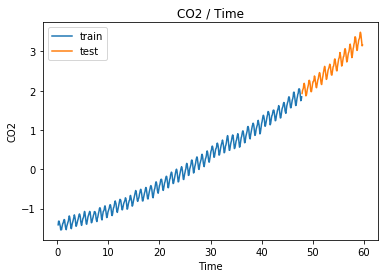

In [56]:
plt.plot(X_train, y_train, label='train')
plt.plot(X_test, y_test, label='test')
plt.legend()
plt.xlabel('Time')
plt.ylabel('CO2')
plt.title('CO2 / Time');

<br/> <!--Intentionally left blank-->

### Part 4.2

Use [**GPy**](https://pypi.python.org/pypi/GPy) library for training and prediction.
Make sure you've read the documentation!. Consult with the seminar if necessary.

Your general task is:
* to fit a GP and run the predict on the test:
    * useful kernels to combine: `GPy.kern.RBF`, `GPy.kern.Poly`, `GPy.kern.StdPeriodic`, `GPy.kern.White`
* to plot residuals. Inspect them on normality by QQ-plot, try to make them as "normal" as possible
* to provide a point-estimate of $R^2$ score on the test part

In [57]:
import GPy
from sklearn.metrics import r2_score
from scipy.stats import probplot
#m = GPy.models.GPRegression(X, Y)

rbf, poly, stdp, white = GPy.kern.RBF(1), GPy.kern.Poly(1), GPy.kern.StdPeriodic(1), GPy.kern.White(1)

In [58]:
GPmodel_rbf = GPy.models.GPRegression(X_train.reshape(-1,1), y_train.reshape(-1,1), kernel=rbf)
GPmodel_poly = GPy.models.GPRegression(X_train.reshape(-1,1), y_train.reshape(-1,1), kernel=poly)
GPmodel_stdp = GPy.models.GPRegression(X_train.reshape(-1,1), y_train.reshape(-1,1), kernel=stdp)
GPmodel_white = GPy.models.GPRegression(X_train.reshape(-1,1), y_train.reshape(-1,1), kernel=white)

GPmodel_rbf.optimize()
GPmodel_poly.optimize()
GPmodel_stdp.optimize()
GPmodel_white.optimize()

mean_rbf, var_rbf = GPmodel_rbf.predict(X_test.reshape(-1,1))
mean_poly, var_poly = GPmodel_poly.predict(X_test.reshape(-1,1))
mean_stdp, var_stdp = GPmodel_stdp.predict(X_test.reshape(-1,1))
mean_white, var_white = GPmodel_white.predict(X_test.reshape(-1,1))

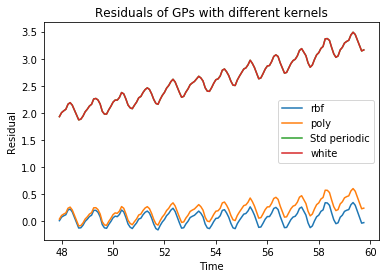

In [59]:
resids_rbf = (y_test - mean_rbf.ravel())# / (var_rbf.ravel())**(.5)
resids_poly = y_test - mean_poly.ravel()# / (var_poly.ravel())**(.5)
resids_stdp = y_test - mean_stdp.ravel()# / (var_stdp.ravel())**(.5)
resids_white = y_test - mean_white.ravel()# / (var_white.ravel())**(.5)

plt.plot(X_test, resids_rbf, label='rbf')
plt.plot(X_test, resids_poly, label='poly')
plt.plot(X_test, resids_stdp,label='Std periodic')
plt.plot(X_test, resids_white, label='white')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Residual')
plt.title('Residuals of GPs with different kernels');

We saw residuals (unnormalized) for different kernels. Let's now try to combine several kernels:

In [60]:
combined_kernel = rbf+poly+stdp+white

In [61]:
GPmodel_combined = GPy.models.GPRegression(X_train.reshape(-1,1), y_train.reshape(-1,1), kernel=combined_kernel)
GPmodel_combined.optimize()

mean_com, var_com = GPmodel_combined.predict(X_test.reshape(-1,1))

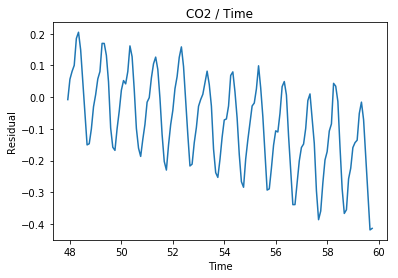

In [62]:
resids_com = y_test - mean_com.ravel()
resids_com_normalized = resids_com / (var_com.ravel())**(.5) #normalized residual

plt.plot(X_test, resids_com)
plt.xlabel('Time')
plt.ylabel('Residual')
plt.title('CO2 / Time');

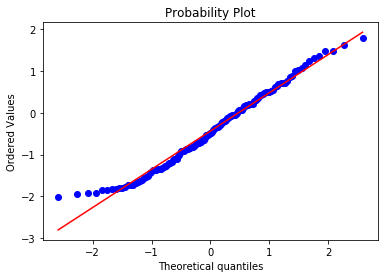

In [63]:
fig,ax = plt.subplots(1)
probplot(resids_com_normalized, dist="norm", plot=ax)
plt.show()

In [64]:
print('R2 score:', r2_score(y_test, mean_com))

R2 score: 0.849909132798
